# [IAPR][iapr]: Lab 2 ‒  Object description


**Author (sciper):** Mehrdad Kiani    (269424)  


**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first import all the packages that will be used during this laboratory. 

Than we extract the `lab-02-data.tar.gz` archive. To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
from numpy.linalg import eig
import cv2
from scipy import ndimage as ndi
import imutils
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.feature import canny
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.color import rgb2gray
from skimage import measure
from skimage.filters import median, sobel_v, sobel_h, sobel, roberts, threshold_local, threshold_otsu, rank
from skimage.morphology import disk, square, rectangle, opening, closing, binary_closing, erosion, dilation
from skimage.filters.rank import autolevel
from skimage.filters.rank import enhance_contrast
from skimage.transform import warp, SimilarityTransform
import skimage.io
from scipy.ndimage import binary_fill_holes
from scipy.fftpack import fft
from scipy.interpolate import interp1d
from math import sqrt
import tarfile
import os
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
%matplotlib inline

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

We use a function to load the images and their names:

In [2]:
def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names

In [3]:
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

We plot the original images

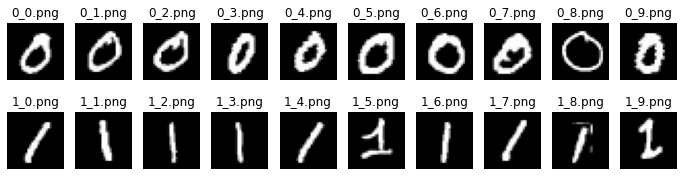

In [4]:
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### 1.1.1 Images pre-processing

To start, we will pre process the images by applying different filters. For the images with zeros we will apply a Gaussian Blur filter, and a binarization with a Otsu threshold. We show below:
1. The original image,
2. The resulting images after the Gaussian filter,
3. The resulting images after the binarization.

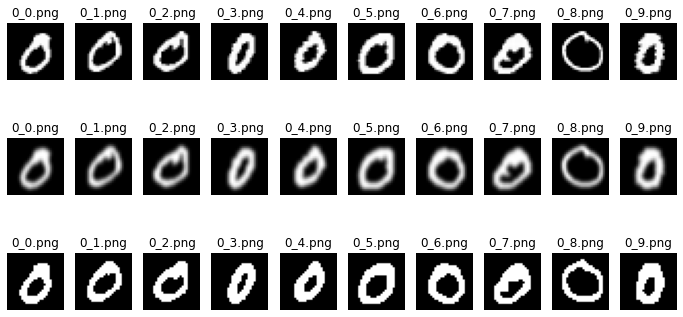

In [5]:
#Preprocessed images of zeros and comparison of different levels of preprocessing

im_bin_zeros = []

fig, axes = plt.subplots(3, len(zeros_im), figsize=(12, 6))

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], zeros_im, zeros_names):
    
    im_gauss  =   cv2.GaussianBlur(im, (3, 5), 0)
    
    ax.imshow(im_gauss, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[2], zeros_im, zeros_names):
    
    im_gauss = cv2.GaussianBlur(im, (3, 5), 0)
    im_bin   = cv2.threshold(im_gauss, 0, 255, cv2.THRESH_OTSU)[1]
    
    im_bin_zeros.append(im_bin)
    ax.imshow(im_bin, cmap = 'gray')
    ax.axis('off')
    ax.set_title(nm)

For the images with ones, we apply an aditional opening step, which allows us to remove small imperfections in the images. We show below:
1. The original image,
2. The resulting images after the Gaussian filter,
3. The resulting images after the binarization.
4. The resulting images after the opening process.

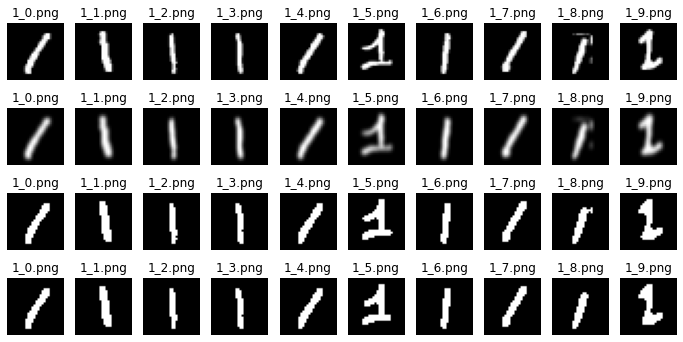

In [6]:
im_bin_ones = []

fig, axes = plt.subplots(4, len(ones_im), figsize=(12, 6))

for ax, im, nm in zip(axes[0], ones_im, ones_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    
    im_gauss  =   cv2.GaussianBlur(im, (3, 5), 0) 
    
    ax.imshow(im_gauss, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[2], ones_im, ones_names):
    
    im_gauss = cv2.GaussianBlur(im, (3, 5), 0)
    im_bin   = cv2.threshold(im_gauss, 0, 255, cv2.THRESH_OTSU)[1]
    
    ax.imshow(im_bin, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[3], ones_im, ones_names):
    
    im_gauss = cv2.GaussianBlur(im, (3, 5), 0)
    im_bin   = cv2.threshold(im_gauss, 0, 255, cv2.THRESH_OTSU)[1]
    im_op    = opening(im_bin, square(2))
    
    im_bin_ones.append(im_op)
    ax.imshow(im_op, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### 1.2.1 Implementation

The Fourier descriptors is a Fourier transform of the contours of shapes inside images. It is a decomposition in

**Frequencies = fundamental frequency + high frequency details**  

For applying this technique wi will define a set of functions for getting the FFT of a serie of points. Also, we define a function to get the amplitude of a complex number. Finally, as it is necessary to have signals of the same length (as clarified in the course forum), we will set a fixed lenght for all contours through an interpolation of the curve. We choose to interpolate the original curves to 200-points curves. This number is greater than the maximum number of points in all contours (87).

In [7]:

def fft_contour(contour):
    u_k = [] # Empty array for signal
    for point in contour:
        u_k.append(complex(real=point[1], imag=point[0])) # We create the real and complex part for each contour point.
    u_k_fft = fft(u_k) # We take the FFT of the contour signal.
    return u_k_fft

def amp_cmplx(cpx_n):
    amplitud = sqrt(cpx_n.real**2 + cpx_n.imag**2) # We compute the amplitud of the signal from the definition.
    return amplitud


def interpolar(points):    
    
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]
    
    alpha = np.linspace(0, 1, 200)
    interpolated_points = {}
    
    interpolator =  interp1d(distance, points, kind='slinear', axis=0) # Creates interpolator object
    interpolated_points = interpolator(alpha)
    return interpolated_points

For each image we need to find the contour and then to those values, apply the FFT function. We use the function measure from skimage to get the contours inside each image. We will keep the biggest one from all the contours detected (this step is important when we have a circle).

Here below, we will plot each image with its selected contour. Also, we plot the normalized amplitudes of both zeros and ones signals. By doing this, we will be able to see how they group in different sectors of the plot. What we look for is to be able to detect two clusters of points that are, at the same time, apart one from the other.

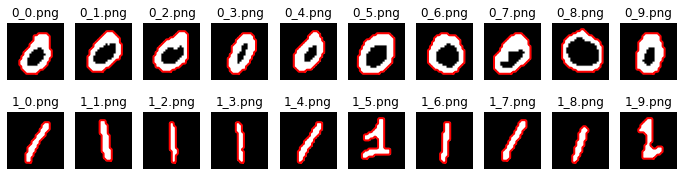

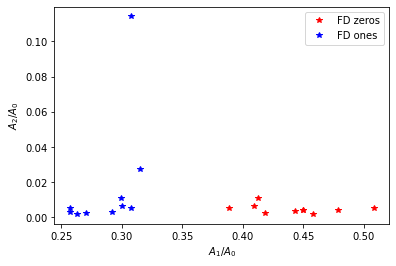

In [8]:
# We initialize the variables for contours and signals.
img_contour_zeros = [] 
img_contour_ones  = [] 

uk_zeros = []
uk_ones  = []


fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    # Find contours 
    contours = measure.find_contours(im)
    # Select the largest contiguous contour
    contour = sorted(contours, key=lambda x: len(x))[-1]
    #Interpolation on the original obtained contour with the number of points we want.
    contour = interpolar(contour)    
    # We store this value in the correspondent array.    
    img_contour_zeros.append(contour)
    # Same for the signal of the contour.
    uk_zeros.append(fft_contour(contour))
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

for ax, im, nm in zip(axes[1], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_ones.append(contour)
    uk_ones.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

    
    
# We plot the amplitudes 1 and 2 normalized by the 0.

fig, ax = plt.subplots()
for ft in uk_zeros:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD zeros')
for ft in uk_ones:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD ones')
    
# We add legend grouping the points by the label given during the plot
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'$A_1/A_0$')
plt.ylabel(r'$A_2/A_0$')
plt.show()

We can see that the results show a good separation between both numbers. If we set a value for the normalized $A_1$ amplitude (e.g. 0.35), we should be able to differentiate all the ones from zeros.

#### 1.2.2 Invariance to rotation, translation and scaling 

In this part we are interested in proving that this method is invariant when we apply different operations to images. For proving it we will apply different transformations to the pre-processed images, and then we will follow the same steps as in the previous section.

We define the functions for rotating, translating, and scaling lists of images.

- **Rotation:** We use the function *rotate* from the package *imutils*. We define the function in such way that the rotation is made with a random angle.  

- **Translation:** We use the function *warpAffine* from the package *openCV*. We define the function in such way that the translation is applied with a random value between -2 and 2. This small value is to avoid parts of the number goes out of the image. We will see, however, that this will represent a problem further in the exercise.

- **Scaling:** We use the function *resize* from the package *openCV*. We define the function in such way that the scaling is applied with a random value between 50% and 150% of the original size of the image. 

In [9]:
def rotate_img(imgs):
    rotated = []
    for item in range(len(imgs)):
        rotated.append(imutils.rotate(imgs[item], angle=random.randint(0, 360)))
    return rotated

def translate_img(imgs):
    translated = []
    for item in range(len(imgs)):
        rows,cols = imgs[item].shape
        transX = random.uniform(-2, 2)
        transY = random.uniform(-2, 2)
        M = np.float32([[1,0,transX],[0,1,transY]])
        d = cv2.warpAffine(imgs[item], M, (cols,rows))
        translated.append(d)
    return translated

def scale_image(imgs):
    output_imgs = []
    for item in range(len(imgs)):
        rfx = random.uniform(0.5, 1.5)
        rfy = random.uniform(0.5, 1.5)
        output_imgs.append(cv2.resize(imgs[item], None, fx = rfx, fy = rfy, interpolation = cv2.INTER_CUBIC))
    return output_imgs

##### Rotation  

We apply the **rotation** function for both sets of pre-processed images. We plot the result of the function right below.

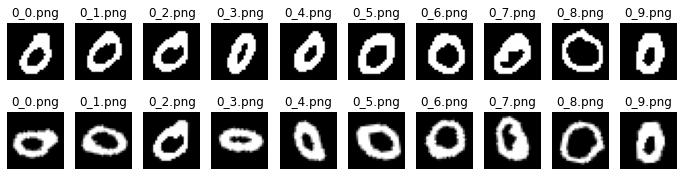

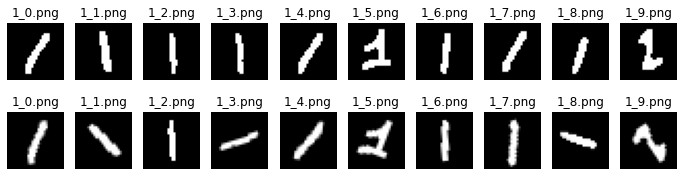

In [10]:
rotated_zeros = rotate_img(im_bin_zeros)
rotated_ones  = rotate_img(im_bin_ones)

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], rotated_zeros, zeros_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)    
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_ones, ones_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], rotated_ones, ones_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)    

We can see that the rotation was successful both for the zeros and the ones.

Now, we apply the same process as before to the rotated images:  
1. We get the contours,
2. We select the largest for each image,
3. We interpolate the curve to get the same lenght for every digit,
4. We compute the FFT of the series of points.

After that we just plot the results and the map of points for the amplitudes $A_1$ and $A_2$ normalized.

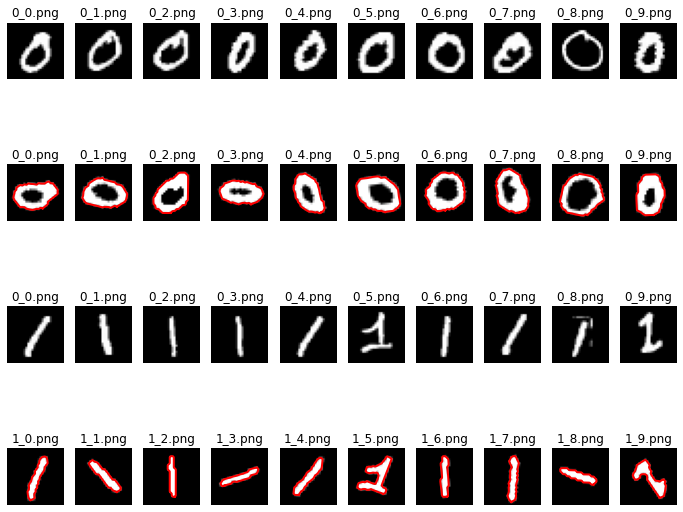

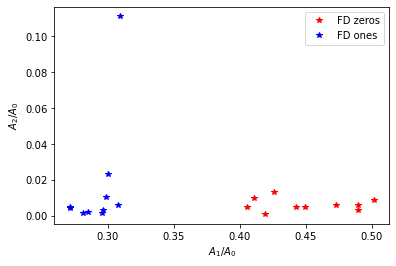

In [11]:
img_contour_rotated_zeros = [] 
img_contour_rotated_ones  = [] 

uk_zeros_rotated = []
uk_ones_rotated  = []

fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 10))


for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], rotated_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)     
    img_contour_rotated_zeros.append(contour)
    uk_zeros_rotated.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

for ax, im, nm in zip(axes[2], ones_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[3], rotated_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    img_contour_rotated_ones.append(contour)
    contour = interpolar(contour)    
    uk_ones_rotated.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    

    
fig, ax = plt.subplots()
for ft in uk_zeros_rotated:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD zeros')
for ft in uk_ones_rotated:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'$A_1/A_0$')
plt.ylabel(r'$A_2/A_0$')
plt.show()

The results are very similar to the previous ones. The threshold we set for the original set of images (i.e., $A_1/A_0 = 0.35$) is still valid. This is explained because we are using $A_1$ and $A_2$, and the only value affected by the rotation is **the phase, not the amplitude.**


We do the same for the **translation function.** We will plot the original set of pre-processed images along with the translated set.

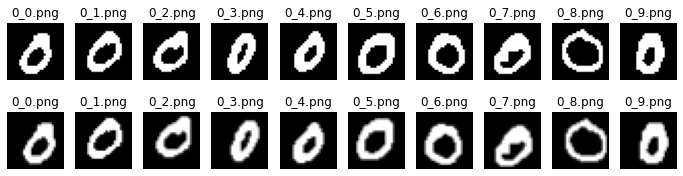

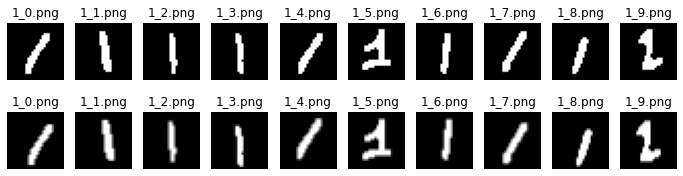

In [12]:
translated_zeros = translate_img(im_bin_zeros)
translated_ones  = translate_img(im_bin_ones)

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], translated_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)    
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], translated_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)  

After seeing that the images are translated, we follow the same process as before, now for the translated images:  

1. We get the contours,
2. We select the largest for each image,
3. We interpolate the curve to get the same lenght for every digit,
4. We compute the FFT of the series of points.

After that we just plot the results and the map of points for the amplitudes $A_1$ and $A_2$ normalized.

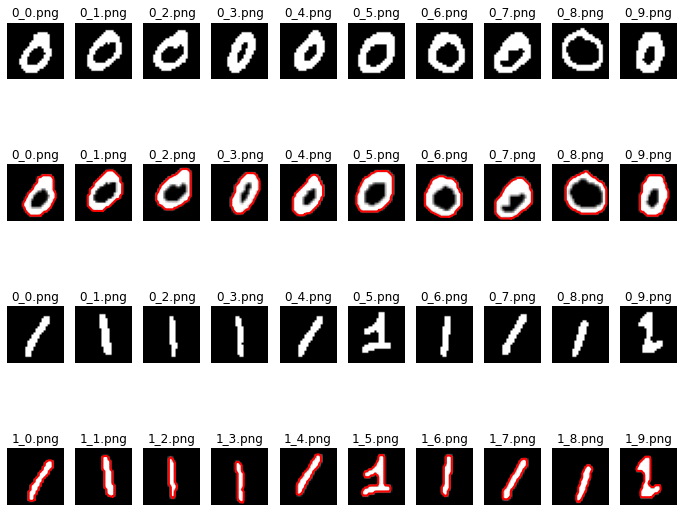

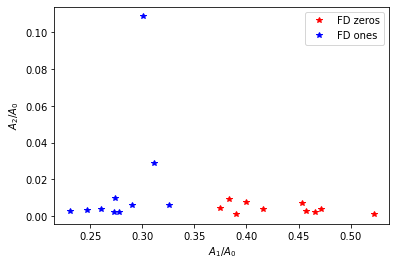

In [13]:
img_contour_translated_zeros = [] 
img_contour_translated_ones  = [] 

uk_zeros_translated = []
uk_ones_translated  = []

fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 10))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], translated_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_translated_zeros.append(contour)
    uk_zeros_translated.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

for ax, im, nm in zip(axes[2], im_bin_ones, zeros_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[3], translated_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_translated_ones.append(contour)
    uk_ones_translated.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
fig, ax = plt.subplots()
for ft in uk_zeros_translated:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD zeros')
for ft in uk_ones_translated:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'$A_1/A_0$')
plt.ylabel(r'$A_2/A_0$')
plt.show()

Here the results are still good. The threshold of 0.35 is again valid, because **the translation function produces a variation in the value of $A_0$**, but it changes proportionally the ratio for all points.

Finally, we apply the same process to the images, but now with a scaling function.

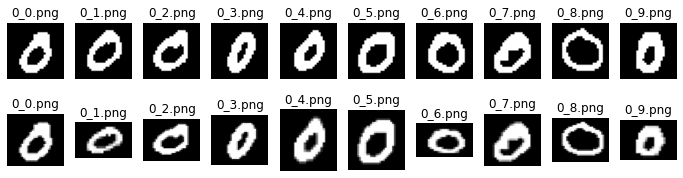

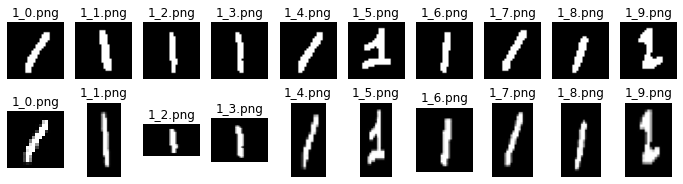

In [14]:
scaled_zeros = scale_image(im_bin_zeros)
scaled_ones  = scale_image(im_bin_ones)

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], scaled_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)    
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], scaled_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)  

We can see that the images were scaled without keeping the aspect ratio. This is a more complex and general application of the function that we wanted to try. Once again we apply the same process as before:  

1. We get the contours,
2. We select the largest for each image,
3. We interpolate the curve to get the same lenght for every digit,
4. We compute the FFT of the series of points.

After that we just plot the results and the map of points for the amplitudes $A_1$ and $A_2$ normalized.

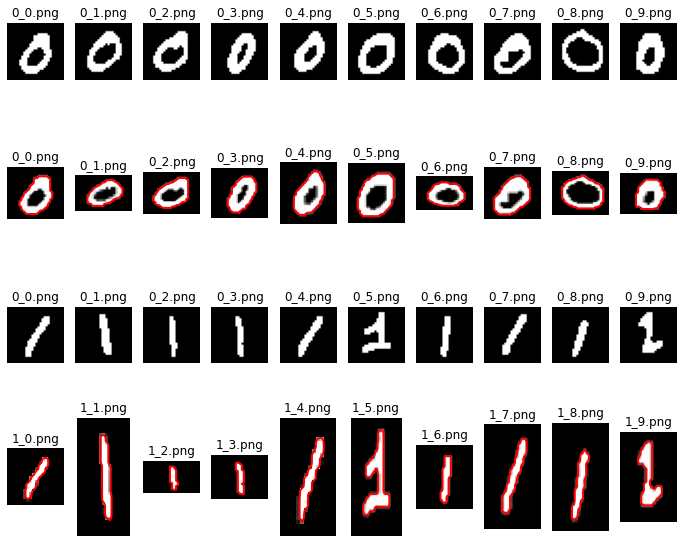

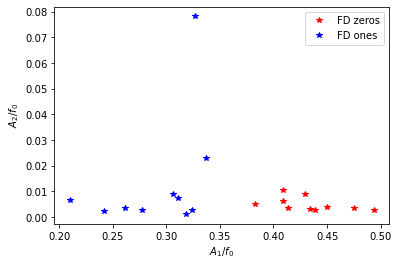

In [15]:
img_contour_scaled_zeros = [] 
img_contour_scaled_ones  = [] 
uk_zeros_scaled = []
uk_ones_scaled  = []

fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 10))


for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], scaled_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_scaled_zeros.append(contour)
    uk_zeros_scaled.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

for ax, im, nm in zip(axes[2], im_bin_ones, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[3], scaled_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_scaled_ones.append(contour)
    uk_ones_scaled.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    

fig, ax = plt.subplots()
for ft in uk_zeros_scaled:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD zeros')
for ft in uk_ones_scaled:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'$A_1/f_0$')
plt.ylabel(r'$A_2/f_0$')
plt.show()

The results are good again. The division between both categories is still around 0.35, which allows us to state that the three operations we applied are not modifying the results of the technique, and that is a very robust and fast methodology.

Now, we want to apply the same process but to a set of images that went under the three operations. Here below we plot the results of this three operations applied to both sets of images. The order we follow for the operations was:  
1. Translation,
2. Scaling,
3. Rotation.

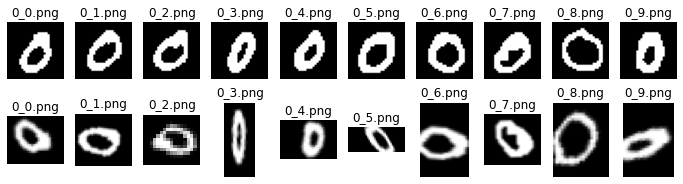

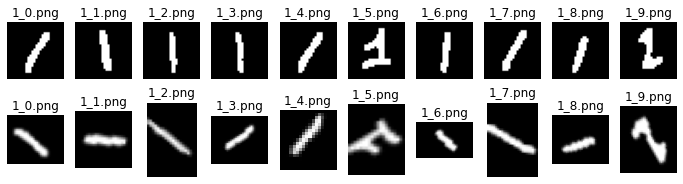

In [16]:
# First, we translate
translated_zeros = translate_img(im_bin_zeros)
translated_ones  = translate_img(im_bin_ones)

# Then we scale
scaled_zeros = scale_image(translated_zeros)
scaled_ones  = scale_image(translated_ones)

# finally, we rotate
final_zeros = rotate_img(scaled_zeros)
final_ones  = rotate_img(scaled_ones)


fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], final_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)    
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], final_ones, ones_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)  

We can see that the results are correct, and all the operations were applied to the pre-processed images. Now we apply the same procedure as before. We will begin with the set of images of Zeros, and then we will continue with the images with Ones.

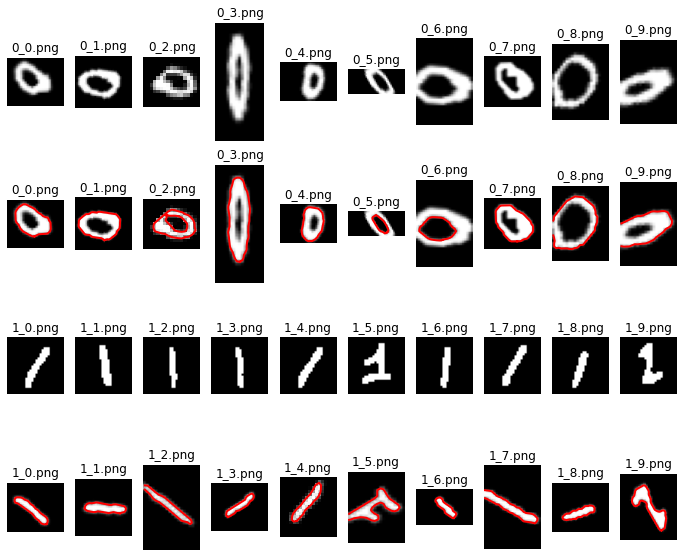

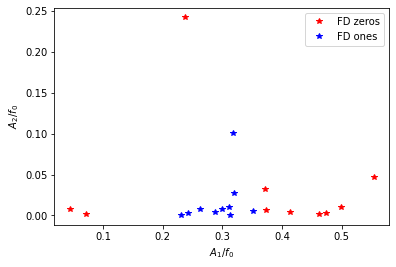

In [17]:
img_final_contour_zeros = [] 
img_final_contour_ones  = [] 

uk_zeros_final = []
uk_ones_final  = []

fig, axes = plt.subplots(4, len(im_bin_zeros), figsize=(12, 10))

for ax, im, nm in zip(axes[1], final_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_zeros.append(contour)
    uk_zeros_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
    
for ax, im, nm in zip(axes[0], final_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)    
    
for ax, im, nm in zip(axes[2], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[3], final_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_ones.append(contour)
    uk_ones_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
fig, ax = plt.subplots()
for ft in uk_zeros_final:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD zeros')
for ft in uk_ones_final:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'$A_1/f_0$')
plt.ylabel(r'$A_2/f_0$')
plt.show()

The results here are worst than before. This is explained because the scaling process, together with the translation operation, produced some numbers to move out of the boundaries. Nevertheless, is still possible to differentiate both group of numbers where a few images fall on the wrong side of the threshold. 
It is important to notice that these results depend on the random values we are using for the operations. When the translation and the aspect ratio changes considerably, we will have a worst result. Our logic says that this result is what should occur.

### 1.3 Additional method (5 pts)

Region-based descriptors (simple ones) are implemented as additional method. Compacity is chosen as first feature and elongation is chosen as second feature. Compacity is invariant in translation, rotation and scaling but it is sensitive to the definition of A and P. Area is considered as part inner contour which is calculate by *contourArea* function in cv2 module. Perimeter is calculated by module called *arclength* in cv2 on the contours that are found by function called *findContours* in cv2. 

Elongation is the ratio between the maximum diameter of the object and its minimum diameter perpendicular to it, but also can be defined as the square root of the ratio of the eigenvalues of the matrix of inertia. Covariance matrix of an object is matrix of inertia. Covariance matrix of the object is 2x2 in 2D, it summarizes the distribution of the shape of the object.
Therefore, first and second order moments are found via moment function in cv2 module. First order moments give the mean and second order moments give the variance. Finally, elongation is computed by eigenvalues as explained above that of the covariance matrix. 

Following procedure is implemented in this part:
    
1) Compacity and elongation features are checked for zeros and ones in the original images. 

2) Compacity and elongation features are checked on randomly rotated images.

3) Compacity and elongation features are checked on randomly translated images.

4) Compacity and elongation features are checked on randomly scaled images.

5) Compacity and elongation features are checked on randomly rotated, translated, scaled images.

Comments about the results are at the end of the section.

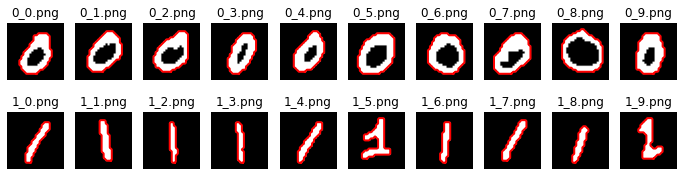

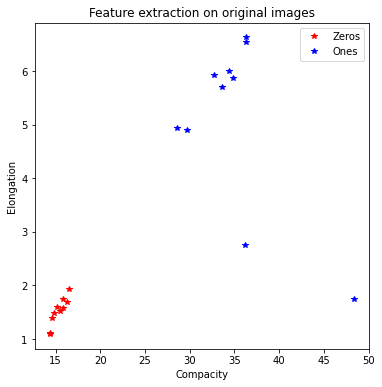

In [18]:
#Detailed explanation will be done only for this cell since others cells contain same procedure
#but on rotated, translated, and scaled images
#Initialization of empty compacity and elongation arrays for zeros and ones.
im_ones_compa=[]
im_zeros_compa=[]
elong_0=[]
elong_1=[]

#In this part contours are drawn on original objects. Compacity and elongation features are extracted for zeros and and ones
# and plotted. 
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_0 = measure.find_contours(im) #Finding iso-valued contours in a 2D array for given images from skimage module. 
    contour_0 = sorted(contours_0, key=lambda x: len(x))[-1]
    img_contour_zeros.append(contour_0) #Contours of zeros.
    con_cov = np.expand_dims(contour_0.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov) #Conversion of type of contours of zeros to apply area function.
    im_zeros_area = cv2.contourArea(con_cov) #Area inside the contours of zeros.
    im_zeros_peri = cv2.arcLength(con_cov,True) #Perimeter of contours of zeros.
    zeros_compa = (im_zeros_peri**2)/im_zeros_area #Compacity of zeros
    im_zeros_compa.append(zeros_compa)
    moment = cv2.moments(im) #Moments for each object
    cov_mat = np.array([[moment['mu20'], moment['mu11']], #Covariance matix for each image to calculate eigenvalues
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5 #Elongation of zeros calculated from square root of ratio of eigenvalues.
    elong_0.append(elong)
    ax.plot(contour_0[:, 1], contour_0[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[1], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_1 = measure.find_contours(im)
    contour_1 = sorted(contours_1, key=lambda x: len(x))[-1]
    img_contour_ones.append(contour_1)
    con_cov = np.expand_dims(contour_1.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_ones_area = cv2.contourArea(con_cov)
    im_ones_peri = cv2.arcLength(con_cov,True)
    ones_compa = (im_ones_peri**2)/im_ones_area
    im_ones_compa.append(ones_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    elong_1.append(elong)
    ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2, color='red')
    
#Plotting the features for zeros and ones
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(im_zeros_compa, elong_0, 'r*', label='Zeros')
ax.plot(im_ones_compa, elong_1, 'b*', label='Ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'Compacity')
plt.ylabel(r'Elongation')
plt.title('Feature extraction on original images')
plt.show()

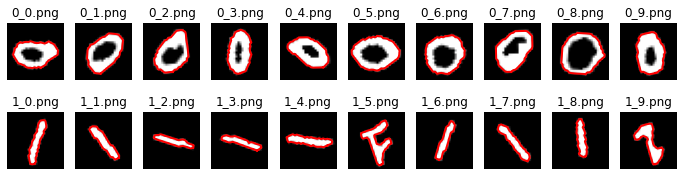

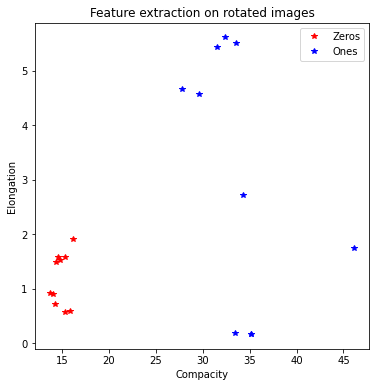

In [19]:
#Rotation of images
rotated_zeros = rotate_img(im_bin_zeros)
rotated_ones  = rotate_img(im_bin_ones)
rot_im_ones_compa=[]
rot_im_zeros_compa=[]
rot_elong_0=[]
rot_elong_1=[]

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], rotated_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_0 = measure.find_contours(im)
    contour_0 = sorted(contours_0, key=lambda x: len(x))[-1]
    img_contour_zeros.append(contour_0)
    con_cov = np.expand_dims(contour_0.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_zeros_area = cv2.contourArea(con_cov)
    im_zeros_peri = cv2.arcLength(con_cov,True)
    zeros_compa = (im_zeros_peri**2)/im_zeros_area
    rot_im_zeros_compa.append(zeros_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    rot_elong_0.append(elong)
    ax.plot(contour_0[:, 1], contour_0[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[1], rotated_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_1 = measure.find_contours(im)
    contour_1 = sorted(contours_1, key=lambda x: len(x))[-1]
    img_contour_ones.append(contour_1)
    con_cov = np.expand_dims(contour_1.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_ones_area = cv2.contourArea(con_cov)
    im_ones_peri = cv2.arcLength(con_cov,True)
    ones_compa = (im_ones_peri**2)/im_ones_area
    rot_im_ones_compa.append(ones_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    rot_elong_1.append(elong)
    ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2, color='red')
    
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(rot_im_zeros_compa, rot_elong_0, 'r*', label='Zeros')
ax.plot(rot_im_ones_compa, rot_elong_1, 'b*', label='Ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'Compacity')
plt.ylabel(r'Elongation')
plt.title('Feature extraction on rotated images')
plt.show()

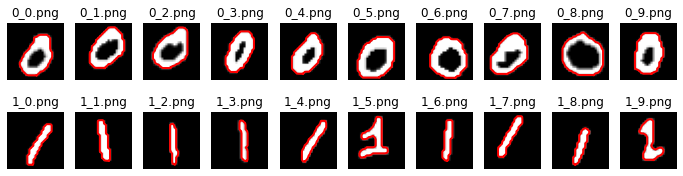

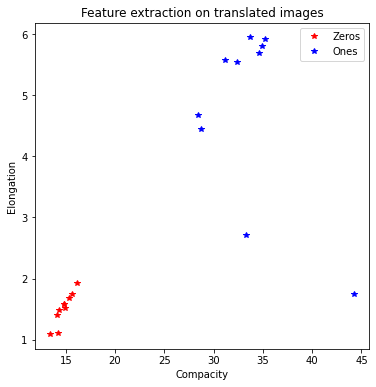

In [20]:
#Translation of images
translated_zeros = translate_img(im_bin_zeros)
translated_ones  = translate_img(im_bin_ones)
tra_im_ones_compa=[]
tra_im_zeros_compa=[]
tra_elong_0=[]
tra_elong_1=[]

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], translated_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_0 = measure.find_contours(im)
    contour_0 = sorted(contours_0, key=lambda x: len(x))[-1]
    img_contour_zeros.append(contour_0)
    con_cov = np.expand_dims(contour_0.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_zeros_area = cv2.contourArea(con_cov)
    im_zeros_peri = cv2.arcLength(con_cov,True)
    zeros_compa = (im_zeros_peri**2)/im_zeros_area
    tra_im_zeros_compa.append(zeros_compa)

    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    tra_elong_0.append(elong)
    
    ax.plot(contour_0[:, 1], contour_0[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[1], translated_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_1 = measure.find_contours(im)
    contour_1 = sorted(contours_1, key=lambda x: len(x))[-1]
    img_contour_ones.append(contour_1)
    con_cov = np.expand_dims(contour_1.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_ones_area = cv2.contourArea(con_cov)
    im_ones_peri = cv2.arcLength(con_cov,True)
    ones_compa = (im_ones_peri**2)/im_ones_area
    tra_im_ones_compa.append(ones_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    tra_elong_1.append(elong)
    
    ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2, color='red')
    
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(tra_im_zeros_compa, tra_elong_0, 'r*', label='Zeros')
ax.plot(tra_im_ones_compa, tra_elong_1, 'b*', label='Ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'Compacity')
plt.ylabel(r'Elongation')
plt.title('Feature extraction on translated images')
plt.show()

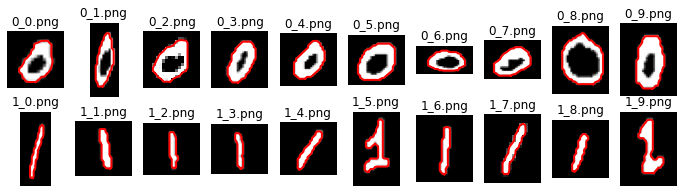

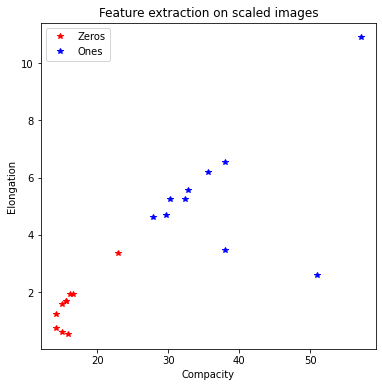

In [21]:
#Scaling of images
scaled_zeros = scale_image(im_bin_zeros)
scaled_ones  = scale_image(im_bin_ones)
sca_im_ones_compa=[]
sca_im_zeros_compa=[]
sca_elong_0=[]
sca_elong_1=[]

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], scaled_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_0 = measure.find_contours(im)
    contour_0 = sorted(contours_0, key=lambda x: len(x))[-1]
    img_contour_zeros.append(contour_0)
    con_cov = np.expand_dims(contour_0.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_zeros_area = cv2.contourArea(con_cov)
    im_zeros_peri = cv2.arcLength(con_cov,True)
    zeros_compa = (im_zeros_peri**2)/im_zeros_area
    sca_im_zeros_compa.append(zeros_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    sca_elong_0.append(elong)
    
    ax.plot(contour_0[:, 1], contour_0[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[1], scaled_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_1 = measure.find_contours(im)
    contour_1 = sorted(contours_1, key=lambda x: len(x))[-1]
    img_contour_ones.append(contour_1)
    con_cov = np.expand_dims(contour_1.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_ones_area = cv2.contourArea(con_cov)
    im_ones_peri = cv2.arcLength(con_cov,True)
    ones_compa = (im_ones_peri**2)/im_ones_area
    sca_im_ones_compa.append(ones_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    sca_elong_1.append(elong)
    
    ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2, color='red')
    
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(sca_im_zeros_compa, sca_elong_0, 'r*', label='Zeros')
ax.plot(sca_im_ones_compa, sca_elong_1, 'b*', label='Ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'Compacity')
plt.ylabel(r'Elongation')
plt.title('Feature extraction on scaled images')
plt.show()

In [22]:
#All operations applied at the same time to images
translated_zeros_add = translate_img(im_bin_zeros)
translated_ones_add  = translate_img(im_bin_ones)

scaled_zeros_add = scale_image(translated_zeros_add)
scaled_ones_add  = scale_image(translated_ones_add)

final_zeros_add = rotate_img(scaled_zeros_add)
final_ones_add  = rotate_img(scaled_ones_add)


add_im_ones_compa=[]
add_im_zeros_compa=[]
add_elong_0=[]
add_elong_1=[]

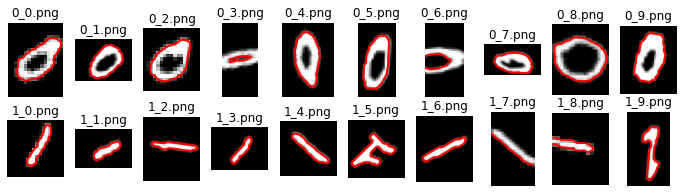

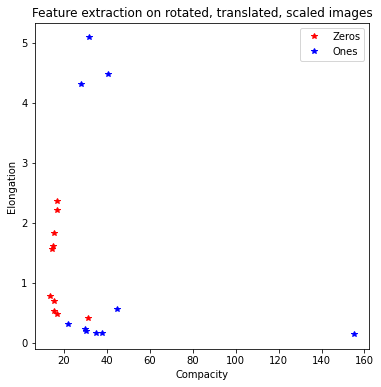

In [23]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, nm in zip(axes[0], final_zeros_add, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_0 = measure.find_contours(im)
    contour_0 = sorted(contours_0, key=lambda x: len(x))[-1]
    img_contour_zeros.append(contour_0)
    con_cov = np.expand_dims(contour_0.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_zeros_area = cv2.contourArea(con_cov)
    im_zeros_peri = cv2.arcLength(con_cov,True)
    zeros_compa = (im_zeros_peri**2)/im_zeros_area
    add_im_zeros_compa.append(zeros_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    add_elong_0.append(elong)
    
    ax.plot(contour_0[:, 1], contour_0[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[1], final_ones_add, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours_1 = measure.find_contours(im)
    contour_1 = sorted(contours_1, key=lambda x: len(x))[-1]
    img_contour_ones.append(contour_1)
    con_cov = np.expand_dims(contour_1.astype(np.float32), 1)
    con_cov = cv2.UMat(con_cov)
    im_ones_area = cv2.contourArea(con_cov)
    im_ones_peri = cv2.arcLength(con_cov,True)
    ones_compa = (im_ones_peri**2)/im_ones_area
    add_im_ones_compa.append(ones_compa)
    moment = cv2.moments(im)
    cov_mat = np.array([[moment['mu20'], moment['mu11']], 
              [moment['mu11'], moment['mu02']]])
    w,v=eig(cov_mat)
    elong=(w[1]/w[0])**0.5
    add_elong_1.append(elong)
    
    ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2, color='red')
    
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(add_im_zeros_compa, add_elong_0, 'r*', label='Zeros')
ax.plot(add_im_ones_compa, add_elong_1, 'b*', label='Ones')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel(r'Compacity')
plt.ylabel(r'Elongation')
plt.title('Feature extraction on rotated, translated, scaled images')
plt.show()

As comments of the results we can state a few things:

1) For original, rotated, translated, and scaled images that are separately done on images, classes are clustered very well. Small intra-class variance for images with zeros is satisfied, however, small intra-class requirement for ones seems not well worked since variance is quite visible on the plots. On the other hand large inter-class variance is satisfied since clear boundary between zeros and ones can be drawn.

2) When rotation, translation, and scaling are applied at the same time to images, compacity and elongation features fail to cluster objects. 

3) It is found out that this kind of perimeter and area approach is correct since none of the compacity values are below $4\pi$ (defined as lower boundary for compacity of circle). 

4) Comparison of region-based and Fourier descriptors show that Fourier descriptors behave better to satisfy small intra-class variance requirement which is not the case for the ones in region-based descriptors. Both methods satisfy large inter-class variance for all cases except where translation, rotation and scaling applied at the same time. This is due to uncapability of contour detection of the objects after operations. In addition, after scaling perfomance of region-based descriptors is worse than Fourier descriptors where requirement of small intra-class and large inter-class variance can bot be seen obviously. Two feature extraction can be considered as valid for both descriptors for two digits.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

In this part, same features of "2" and "3" are tried to be extracted in addition to "0" and "1". 
Following procedure is applied:

1) Same Fourier descriptors are implemented as in the first part that ratio of the Fourier descriptors are used as feature to be invariant to scaling and these descriptors belong to low frequencies are the initial ones and normalization is done with initial descriptor. This is done for all digits. Then, features are extracted with high frequencies which are the last descriptors. Although it is known from the course that low frequency Fourier descriptors are used for the shape of the objects, result of the high frequencies might work as well. Fourier transform of the contours decomposition in frequencies (low+medium+high).
2) Three features are extracted to discriminate four digits, so features are plotted in 3D space after uncapability of 2 features for the discrimination.

3) Procedure in points 1 and 2 is applied for rotated, translated, and scaled images (not separate application) for all digits.

Outcomes:

1) Feature exctraction in 2D seems inefficient. Low frequencies do not discriminate the digits, however, working with high frequencies better than low frequencies. Inter-class variance seems satisfied for zeros, ones and threes, however, this is not the case for twos. Twos spread over the plot and they can not be discriminated from other digits. Small intra-class variance is not perfect since some of the objects remain far from the others. Clustering of four digits by two features does not work well.

2) Three features are extracted in high frequencies (last three descriptors). Discrimination can be done better except for twos. Twos still merge with the other classes where large inter-class variance can not be satisfied.

3) Feature extraction of rotated, translated, scaled images show that both low and high frequencies fail to satisfy four requirements (small intra-class variance, large inter-class variance, small number of features) even under two features or three features.

 If we are interested only in the general shape, we are interested in low frequencies. To be invariant to translation we ignore first coefficient, to be invariant to rotation we consider amplitude, to be invariant to scaling we consider the ratio between two Fourier descriptors (scale by one the descriptor). We do last one for amplitude and we will be invariant to all.


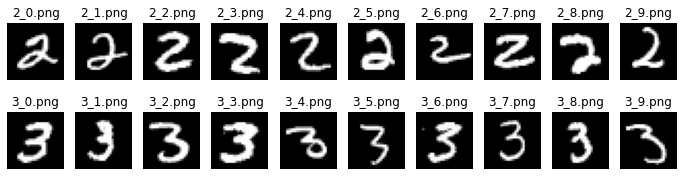

In [24]:
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    


### 2.2 Fourier descriptors - 4 digits (10 pts)

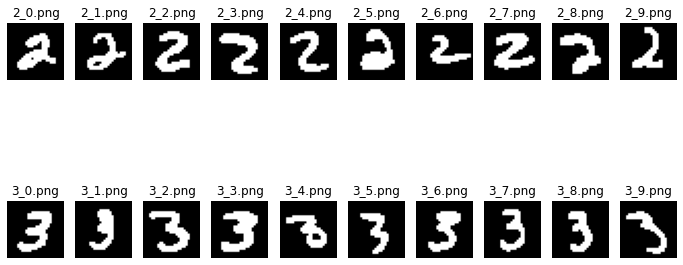

In [25]:
im_bin_twos = []
im_bin_threes = []

fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 6))

for ax, im, nm in zip(axes[0], twos_im, twos_names):
    
    im_gauss = cv2.GaussianBlur(im, (3, 5), 0)
    im_bin   = cv2.threshold(im_gauss, 0, 255, cv2.THRESH_OTSU)[1]
    im_op    = opening(im_bin, square(2))
    im_bin_twos.append(im_op)
    ax.imshow(im_op, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    
    im_gauss = cv2.GaussianBlur(im, (3, 5), 0)
    im_bin   = cv2.threshold(im_gauss, 0, 255, cv2.THRESH_OTSU)[1]
    im_op    = opening(im_bin, square(2))
    im_bin_threes.append(im_op)
    ax.imshow(im_op, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

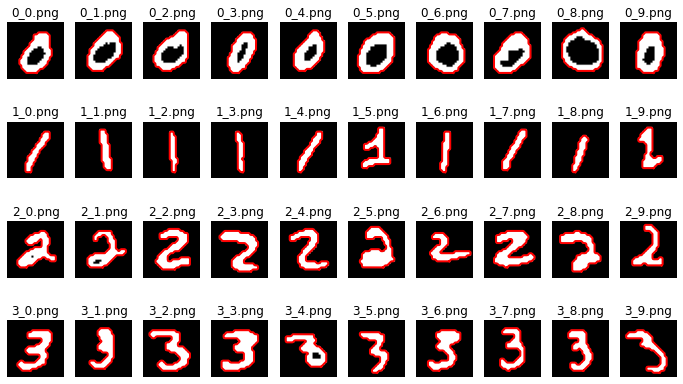

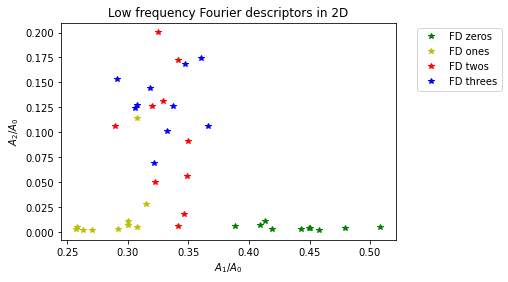

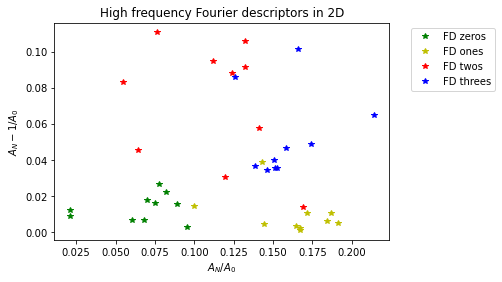

In [26]:
#Initialization of Fourier descriptor arrays for four digits
img_contour_zeros = [] 
img_contour_ones  = [] 
img_contour_twos = [] 
img_contour_threes = [] 

uk_zeros = []
uk_ones  = []
uk_twos = []
uk_threes = []

#Fourier descriptors for all digits
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 7))

for ax, im, nm in zip(axes[0], im_bin_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour) #Interpolation of original obtained contour with the number of points we want.    
    img_contour_zeros.append(contour)
    uk_zeros.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

for ax, im, nm in zip(axes[1], im_bin_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour) 
    img_contour_ones.append(contour)
    uk_ones.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[2], im_bin_twos, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_twos.append(contour)
    uk_twos.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

for ax, im, nm in zip(axes[3], im_bin_threes, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_contour_threes.append(contour)
    uk_threes.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

#Fourier descriptors for low frequencies
fig, ax = plt.subplots()
for ft in uk_zeros:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'g*', label='FD zeros')
for ft in uk_ones:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'y*', label='FD ones') 
for ft in uk_twos:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD twos')
for ft in uk_threes:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD threes')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r'$A_1/A_0$')
plt.ylabel(r'$A_2/A_0$')
plt.title('Low frequency Fourier descriptors in 2D')
plt.show()    

#Fourier descriptors for high frequencies
fig, ax = plt.subplots()
for ft in uk_zeros:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'g*', label='FD zeros')
for ft in uk_ones:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'y*', label='FD ones') 
for ft in uk_twos:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'r*', label='FD twos')
for ft in uk_threes:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'b*', label='FD threes')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r'$A_N/A_0$')
plt.ylabel(r'$A_N-1/A_0$')
plt.title('High frequency Fourier descriptors in 2D')
plt.show()

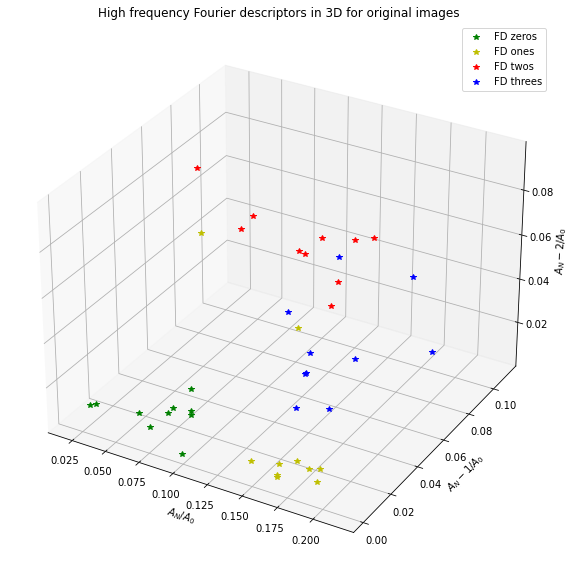

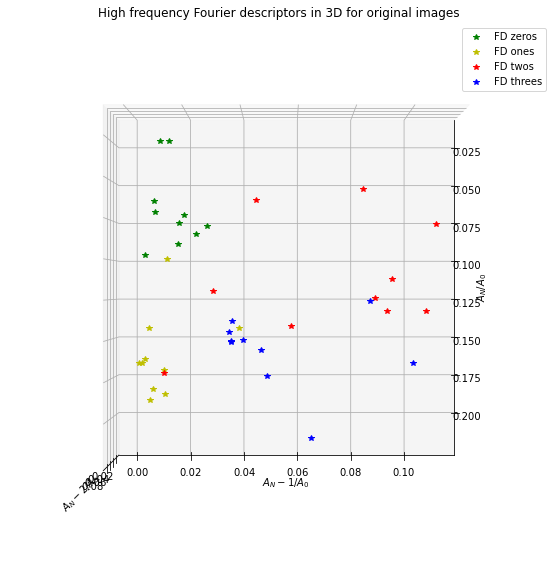

In [27]:
#3 features that are considered in high frequencies
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection='3d')
for ft in uk_zeros:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'g*', label='FD zeros')
for ft in uk_ones:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'y*', label='FD ones') 
for ft in uk_twos:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'r*', label='FD twos')
for ft in uk_threes:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'b*', label='FD threes')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlabel(r'$A_N/A_0$')
ax.set_ylabel(r'$A_N-1/A_0$')
ax.set_zlabel(r'$A_N-2/A_0$')
plt.title('High frequency Fourier descriptors in 3D for original images')
plt.show()   

ax.view_init(90,0)
fig

In [28]:
#All operations applied at the same time to digits of 2 and 3
translated_twos = translate_img(im_bin_twos)
translated_threes  = translate_img(im_bin_threes)

scaled_twos = scale_image(translated_twos)
scaled_threes  = scale_image(translated_threes)

final_twos = rotate_img(scaled_twos)
final_threes = rotate_img(scaled_threes)

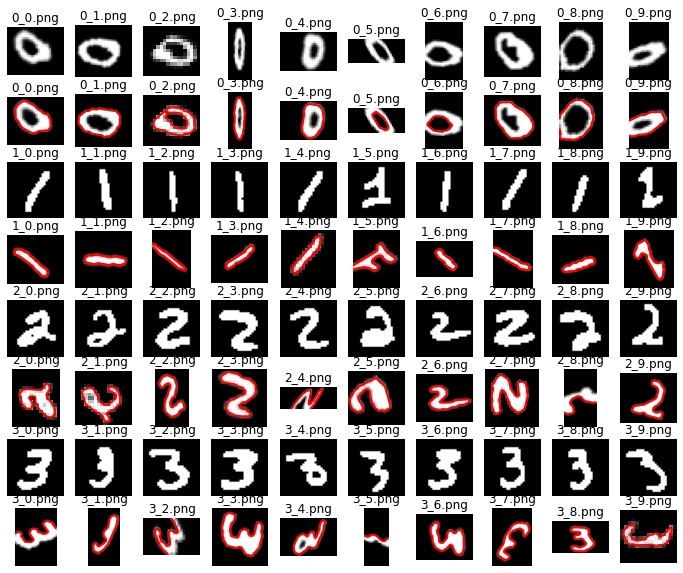

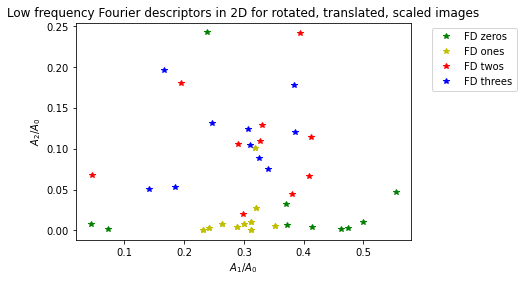

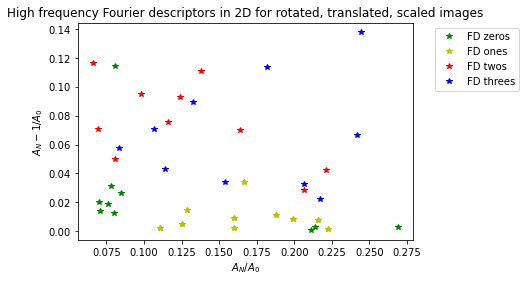

In [29]:
#Feature extraction of digits on rotated, translated, and scaled images with two featues
img_final_contour_zeros = [] 
img_final_contour_ones  = [] 
img_final_contour_twos = []
img_final_contour_threes  = []


uk_zeros_final = []
uk_ones_final  = []
uk_twos_final = []
uk_threes_final  = []

fig, axes = plt.subplots(8, len(im_bin_zeros), figsize=(12, 10))

for ax, im, nm in zip(axes[0], final_zeros, zeros_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)  

for ax, im, nm in zip(axes[1], final_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_zeros.append(contour)
    uk_zeros_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
      
    
for ax, im, nm in zip(axes[2], im_bin_ones, ones_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[3], final_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_ones.append(contour)
    uk_ones_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[2], im_bin_ones, ones_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[3], final_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_ones.append(contour)
    uk_ones_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[4], im_bin_twos, twos_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[5], final_twos, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_twos.append(contour)
    uk_twos_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
for ax, im, nm in zip(axes[6], im_bin_threes, threes_names):
    
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[7], final_threes, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    contours = measure.find_contours(im)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    contour = interpolar(contour)    
    img_final_contour_threes.append(contour)
    uk_threes_final.append(fft_contour(contour))
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    
    
fig, ax = plt.subplots()
for ft in uk_zeros_final:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'g*', label='FD zeros')
for ft in uk_ones_final:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'y*', label='FD ones') 
for ft in uk_twos_final:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'r*', label='FD twos')
for ft in uk_threes_final:
    ax.plot(amp_cmplx(ft[1])/amp_cmplx(ft[0]), amp_cmplx(ft[2])/amp_cmplx(ft[0]), 'b*', label='FD threes')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r'$A_1/A_0$')
plt.ylabel(r'$A_2/A_0$')
plt.title('Low frequency Fourier descriptors in 2D for rotated, translated, scaled images')
plt.show()    

fig, ax = plt.subplots()
for ft in uk_zeros_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'g*', label='FD zeros')
for ft in uk_ones_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'y*', label='FD ones') 
for ft in uk_twos_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'r*', label='FD twos')
for ft in uk_threes_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), 'b*', label='FD threes')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r'$A_N/A_0$')
plt.ylabel(r'$A_N-1/A_0$')
plt.title('High frequency Fourier descriptors in 2D for rotated, translated, scaled images')
plt.show()

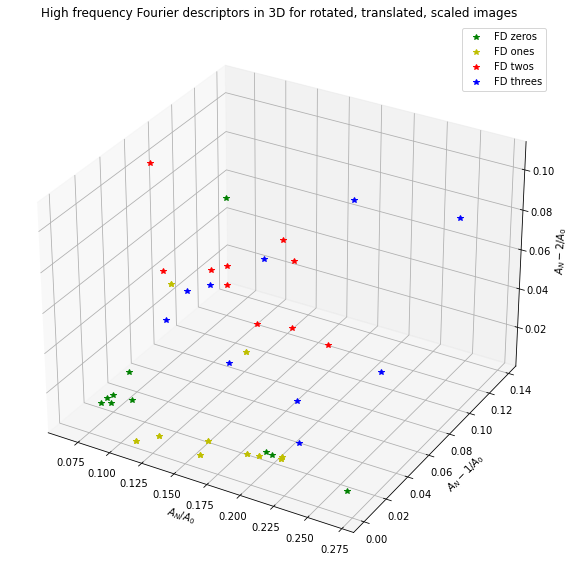

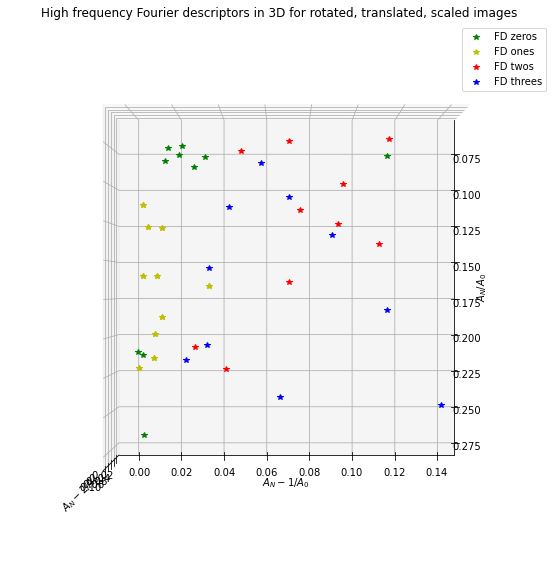

In [30]:
#Feature extraction of digits on rotated, translated, and scaled images with three featues
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection='3d')
for ft in uk_zeros_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'g*', label='FD zeros')
for ft in uk_ones_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'y*', label='FD ones') 
for ft in uk_twos_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'r*', label='FD twos')
for ft in uk_threes_final:
    ax.plot(amp_cmplx(ft[-1])/amp_cmplx(ft[0]), amp_cmplx(ft[-2])/amp_cmplx(ft[0]), amp_cmplx(ft[-3])/amp_cmplx(ft[0]), 'b*', label='FD threes')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlabel(r'$A_N/A_0$')
ax.set_ylabel(r'$A_N-1/A_0$')
ax.set_zlabel(r'$A_N-2/A_0$')
plt.title('High frequency Fourier descriptors in 3D for rotated, translated, scaled images')
plt.show()   

ax.view_init(90,0)
fig